In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch import tensor
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.integrate import solve_ivp, odeint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

# set the path to the project directory
# os.chdir('/Users/olarinoyem/Project/data_driven_vaccination/')

os.chdir("/Users/ajaoo/Desktop/Projects/data_driven_vaccination/")

In [2]:
# Set up matplotlib

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update(
    {
        # Font settings for clarity and compatibility with academic publications
        "font.family": "serif",  # Consistent font family
        # "font.serif": ["Times", "Computer Modern Roman"],  # Preferred serif fonts
        "font.size": 14,  # Base font size for better readability
        "text.usetex": False,  # Enable LaTeX for text rendering for a professional look
        # Figure aesthetics & size for detailed visuals and fit on publication pages
        "figure.figsize": (
            8,
            5,
        ),  # Adjusted figure size for a balance between detail and fit
        "figure.facecolor": "white",  # White figure background for clean print
        "figure.autolayout": True,  # Enable automatic layout adjustments
        "figure.dpi": 400,  # High resolution figures
        "savefig.dpi": 400,  # High resolution saving settings
        "savefig.format": "pdf",  # Save figures in PDF format for publications
        "savefig.bbox": "tight",  # Tight bounding box around figures
        # Axes aesthetics for clarity and precision
        "axes.labelsize": 14,  # Clear labeling with larger font size
        "axes.titlesize": 20,  # Prominent titles for immediate recognition
        "axes.facecolor": "white",  # White axes background
        # Legend aesthetics for distinguishing plot elements
        "legend.fontsize": 12,  # Readable legend font size
        "legend.frameon": False,  # No frame around legend for cleaner look
        "legend.loc": "best",  # Optimal legend positioning
        # Line aesthetics for clear visual distinctions
        "lines.linewidth": 2,  # Thicker lines for visibility
        "lines.markersize": 8,  # Slightly smaller markers for balance
        # Tick label sizes for readability
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "xtick.direction": "in",  # Ticks inside the plot
        "ytick.direction": "in",  # Ticks inside the plot
    }
)

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# load the data and check the first few rows
df = pd.read_csv("data/processed/england_data.csv").drop(columns=["Unnamed: 0"], axis=1)
df.head()

,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,areaName
0,2020-04-01,0.0,31201,15544.0,4382,3989.0,694.0,35571.0,4730.0,56171302,England
1,2020-04-02,1878.0,35138,15364.0,3937,3895.0,725.0,39466.0,5455.0,56171302,England
2,2020-04-03,2261.0,38526,18158.0,3388,3878.0,737.0,43344.0,6192.0,56171302,England
3,2020-04-04,2458.0,41972,20489.0,3446,3260.0,828.0,46604.0,7020.0,56171302,England
4,2020-04-05,2650.0,45418,22051.0,3446,2994.0,823.0,49598.0,7843.0,56171302,England


In [4]:
params = {
    "alpha": 0.1,  # Rate of transmission from the infected not requiring hospitalization
    "sigma": 0.1,  # Rate of transmission from the infected requiring hospitalization
    "beta": 0.17,  # Rate of transmission from the infected requiring hospitalization
    "gamma": 1 / 16,  # Recovery rate
    "theta": 0.001,  # Mortality rate
    "N": 56171302,  # Total population for England
    # Parameters for hospitalized and critical
    "rho": 0.05,  # Hospitalization rate for infected
    "delta": 0.01,  # Mortality rate for non-hospitalized
    "eta": 0.02,  # Rate at which hospitalized become critical
    "kappa": 0.03,  # Recovery rate for hospitalized
    "mu": 0.01,  # Recovery rate for critical
    "xi": 0.005,  # Mortality rate for critical
}

# Initial conditions [S0, I0, H0, C0, R0, D0] based on early data for England
initial_conditions = [params["N"] - 1, 1, 0, 0, 0, 0]

In [5]:
def load_and_preprocess_data(
    filepath, recovery_period=16, rolling_window=7, start_date="2020-04-01"
):
    """
    Load and preprocess the COVID-19 dataset for the SIHCRD model.

    Parameters:
    - filepath: Path to the CSV file containing the data.
    - recovery_period: Assumed number of days for recovery. Defaults to 16 days.
    - rolling_window: Window size for rolling average calculation. Defaults to 7 days.
    - start_date: The start date for filtering the data. Format 'YYYY-MM-DD'.

    Returns:
    - A preprocessed pandas DataFrame suitable for SIHCRD model integration.
    """
    df = pd.read_csv(filepath)

    # Ensure the dataset has the required columns
    required_columns = [
        "date",
        "cumulative_confirmed",
        "cumulative_deceased",
        "population",
        "covidOccupiedMVBeds",
        "hospitalCases",
    ]
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Convert date to datetime and calculate days since start
    df["date"] = pd.to_datetime(df["date"])
    df["days_since_start"] = (df["date"] - pd.to_datetime(start_date)).dt.days

    # # Data Quality Checks for cumulative data
    # for col in ["cumulative_confirmed", "cumulative_deceased"]:
    #     if df[col].isnull().any() or (df[col].diff().dropna() < 0).any():
    #         raise ValueError(f"Inconsistent data in column: {col}")

    # Calculate recovered cases assuming a fixed recovery period
    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df[
        "cumulative_deceased"
    ].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)

    # Calculate active cases
    df["active_cases"] = (
        df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]
    )

    # Estimate the susceptible population
    df["S(t)"] = (
        df["population"]
        - df["active_cases"]
        - df["recovered"]
        - df["cumulative_deceased"]
    )

    # Apply rolling average
    for col in ["cumulative_confirmed", "cumulative_deceased", "hospitalCases", "covidOccupiedMVBeds"]:
        df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    # Filter data based on the start date
    df = df[df["date"] >= pd.to_datetime(start_date)].reset_index(drop=True)

    # Ensure no negative values
    df[["recovered", "active_cases", "S(t)"]] = df[
        ["recovered", "active_cases", "S(t)"]
    ].clip(lower=0)

    return df


def split_time_series_data(df, train_size=0.7, val_size=0.15, test_size=0.15):
    """
    Splits the DataFrame into training, validation, and test sets while maintaining the time series order.

    Args:
        df (pd.DataFrame): The input DataFrame with time series data.
        train_size (float): Proportion of the dataset to allocate to training.
        val_size (float): Proportion of the dataset to allocate to validation.
        test_size (float): Proportion of the dataset to allocate to testing.

    Returns:
        tuple: Three DataFrames corresponding to the training, validation, and test sets.
    """
    if not np.isclose(train_size + val_size + test_size, 1.0):
        raise ValueError("train_size, val_size, and test_size should sum to 1.")

    n = len(df)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)

    train_data = df.iloc[:train_end]
    val_data = df.iloc[train_end:val_end]
    test_data = df.iloc[val_end:]

    return train_data, val_data, test_data

In [6]:
data = load_and_preprocess_data(
    "data/processed/england_data.csv",
    recovery_period=21,
    rolling_window=7,
    start_date="2020-04-01",
).drop("Unnamed: 0", axis=1)

data.head()

,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,areaName,days_since_start,recovered,active_cases,S(t)
0,2020-04-01,0.000000,31201,15544.000000,4382,3989.0,694.0,35571.000000,4730.00,56171302,England,0,0.0,30841.0,56135731.0
1,2020-04-02,939.000000,35138,15454.000000,3937,3895.0,725.0,37518.500000,5092.50,56171302,England,1,0.0,34011.0,56131836.0
2,2020-04-03,1379.666667,38526,16355.333333,3388,3878.0,737.0,39460.333333,5459.00,56171302,England,2,0.0,37152.0,56127958.0
3,2020-04-04,1649.250000,41972,17388.750000,3446,3260.0,828.0,41246.250000,5849.25,56171302,England,3,0.0,39584.0,56124698.0
4,2020-04-05,1849.400000,45418,18321.200000,3446,2994.0,823.0,42916.600000,6248.00,56171302,England,4,0.0,41755.0,56121704.0


In [7]:
# select from the beginning of the pandemic in the data to the end of 2021
data = data[(data["date"] >= "2020-04-01") & (data["date"] <= "2020-12-31")]
data = data.reset_index(drop=True)
data.head()

,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,areaName,days_since_start,recovered,active_cases,S(t)
0,2020-04-01,0.000000,31201,15544.000000,4382,3989.0,694.0,35571.000000,4730.00,56171302,England,0,0.0,30841.0,56135731.0
1,2020-04-02,939.000000,35138,15454.000000,3937,3895.0,725.0,37518.500000,5092.50,56171302,England,1,0.0,34011.0,56131836.0
2,2020-04-03,1379.666667,38526,16355.333333,3388,3878.0,737.0,39460.333333,5459.00,56171302,England,2,0.0,37152.0,56127958.0
3,2020-04-04,1649.250000,41972,17388.750000,3446,3260.0,828.0,41246.250000,5849.25,56171302,England,3,0.0,39584.0,56124698.0
4,2020-04-05,1849.400000,45418,18321.200000,3446,2994.0,823.0,42916.600000,6248.00,56171302,England,4,0.0,41755.0,56121704.0


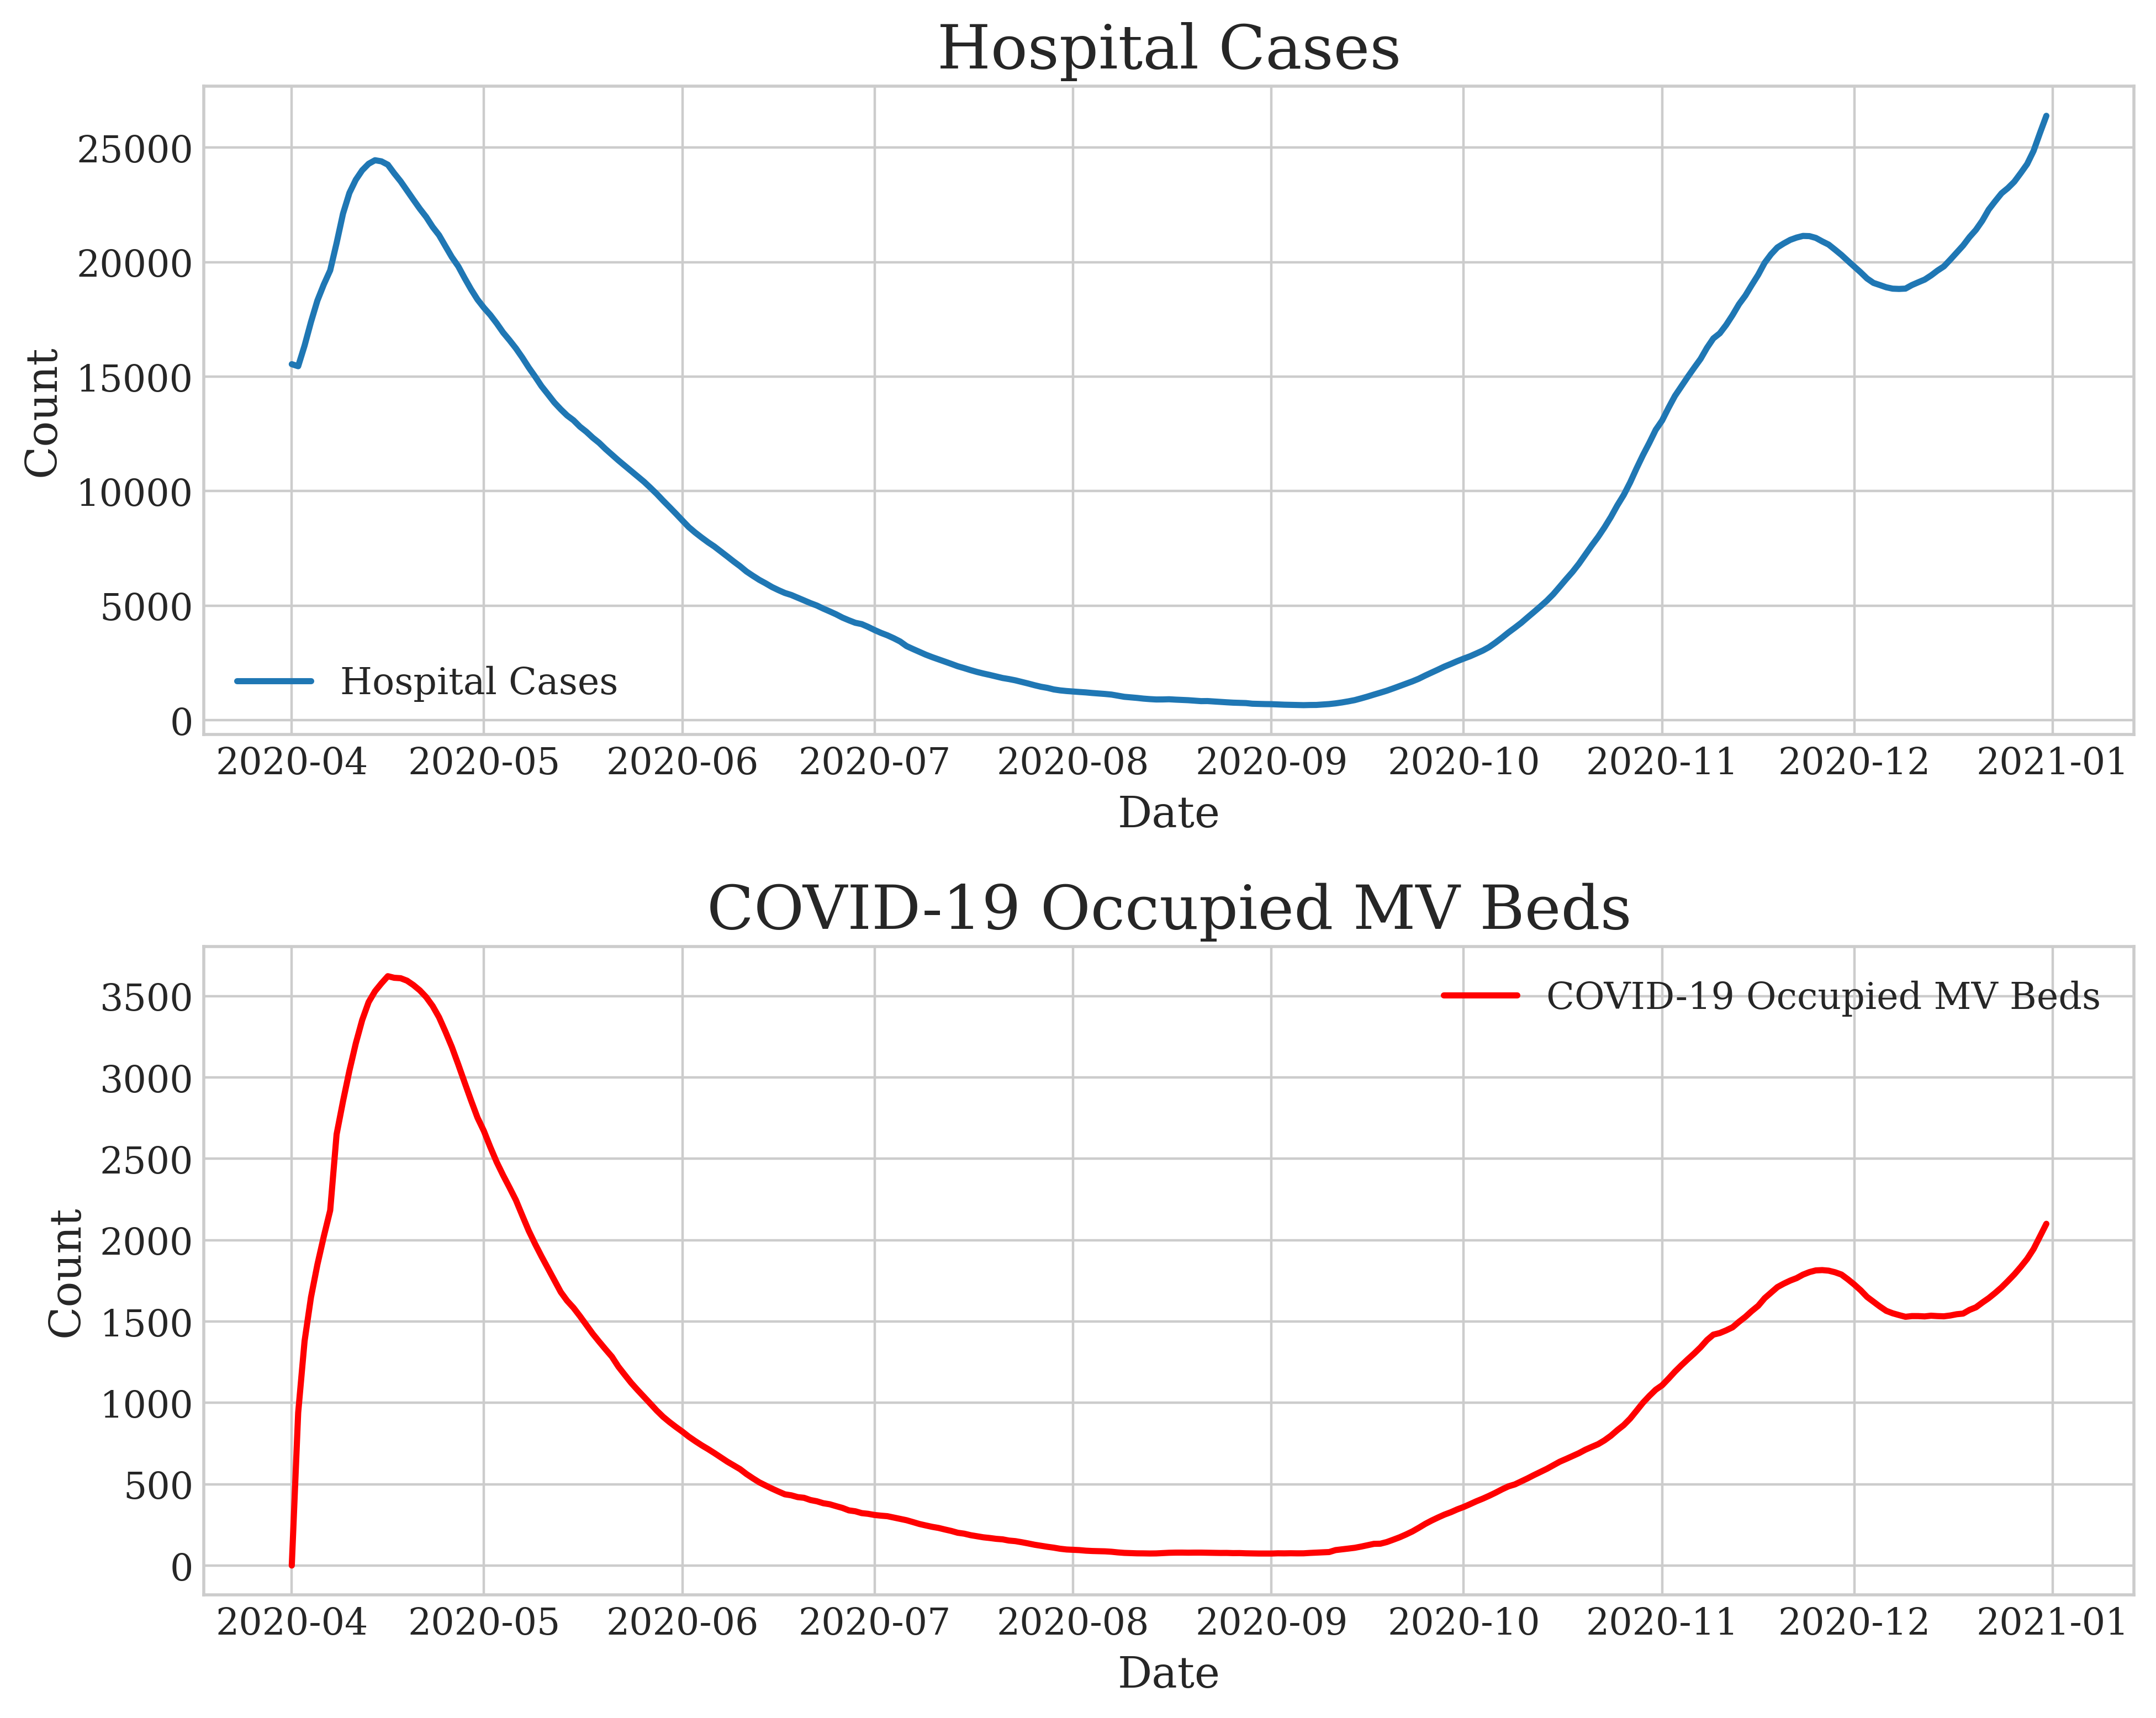

In [8]:
# visualize covidOccupiedMVBeds and hospitalCases on separate subplots
ax, fig = plt.subplots(2, 1, figsize=(10, 8))
fig[0].plot(data["date"], data["hospitalCases"], label="Hospital Cases")
fig[0].set_title("Hospital Cases")
fig[0].set_xlabel("Date")
fig[0].set_ylabel("Count")
fig[0].legend()

fig[1].plot(
    data["date"],
    data["covidOccupiedMVBeds"],
    label="COVID-19 Occupied MV Beds",
    color="red",
)
fig[1].set_title("COVID-19 Occupied MV Beds")
fig[1].set_xlabel("Date")
fig[1].set_ylabel("Count")
fig[1].legend()

plt.tight_layout()
plt.show()

In [9]:
# Split the data into training, validation, and test sets and scale the training data
train_data, val_data, test_data = split_time_series_data(
    data, train_size=0.7, val_size=0.15, test_size=0.15
)

scaler = MinMaxScaler()

In [10]:
def prepare_tensors(data, device):
    # t should be the length of the data starting from 1
    t = tensor(range(1, len(data) + 1), dtype=torch.float32).view(-1, 1).to(device).requires_grad_(True)
    S = tensor(data["S(t)"].values, dtype=torch.float32).view(-1, 1).to(device)
    I = tensor(data["active_cases"].values, dtype=torch.float32).view(-1, 1).to(device)
    R = tensor(data["recovered"].values, dtype=torch.float32).view(-1, 1).to(device)
    D = tensor(data["new_deceased"].values, dtype=torch.float32).view(-1, 1).to(device)
    H = tensor(data["hospitalCases"].values, dtype=torch.float32).view(-1, 1).to(device)
    C = (
        tensor(data["covidOccupiedMVBeds"].values, dtype=torch.float32)
        .view(-1, 1)
        .to(device)
    )
    return t, S, I, R, D, H, C


# Define the specific features used in the model
model_features = ['S(t)', 'active_cases', 'hospitalCases', 'covidOccupiedMVBeds', 'recovered', 'new_deceased']

# Fit the scaler only to these model features
scaler.fit(train_data[model_features])

# Transform the training, validation, and test data
train_data_scaled = pd.DataFrame(scaler.transform(train_data[model_features]), columns=model_features, index=train_data.index)
val_data_scaled = pd.DataFrame(scaler.transform(val_data[model_features]), columns=model_features, index=val_data.index)
test_data_scaled = pd.DataFrame(scaler.transform(test_data[model_features]), columns=model_features, index=test_data.index)

# Prepare tensors for each dataset using the updated scaled data
t_train, S_train, I_train, R_train, D_train, H_train, C_train = prepare_tensors(train_data_scaled, device)
t_val, S_val, I_val, R_val, D_val, H_val, C_val = prepare_tensors(val_data_scaled, device)
t_test, S_test, I_test, R_test, D_test, H_test, C_test = prepare_tensors(test_data_scaled, device)

# Concatenate the tensors for each set
SIHCRD_tensor_train = torch.cat((S_train, I_train, H_train, C_train, R_train, D_train), dim=1)
SIHCRD_tensor_val = torch.cat((S_val, I_val, H_val, C_val, R_val, D_val), dim=1)
SIHCRD_tensor_test = torch.cat((S_test, I_test, H_test, C_test, R_test, D_test), dim=1)


In [11]:
def seihcrd_model(t, y, params):
    S, E, I, H, C, R, D = y
    N = params["N"]
    dSdt = -(params["beta"] * I / N) * S
    dEdt = (params["beta"] * I / N) * S - params["sigma"] * E
    dIdt = params["sigma"] * E - (params["gamma"] + params["rho"] + params["delta"]) * I
    dHdt = params["rho"] * I - (params["eta"] + params["kappa"]) * H
    dCdt = params["eta"] * H - (params["mu"] + params["xi"]) * C
    dRdt = params["gamma"] * I + params["kappa"] * H + params["mu"] * C
    dDdt = params["delta"] * I + params["xi"] * C
    return [dSdt, dEdt, dIdt, dHdt, dCdt, dRdt, dDdt]

def sihcrd_model(t, y, params):
    S, I, H, C, R, D = y
    N = params["N"]
    beta = params["beta"]
    gamma = 0.125
    rho = 0.03
    delta = 0.02
    eta = 0.125
    kappa = 0.01875
    mu = 0.14
    xi = 0.143

    S = N - sum(y)  # Recompute S based on other compartments
    dSdt = -(beta * I / N) * S
    dIdt = (beta * S / N) * I - (gamma + rho + delta) * I
    dHdt = rho * I - (eta + kappa) * H
    dCdt = eta * H - (mu + xi) * C
    dRdt = gamma * I + mu * C
    dDdt = delta * I + xi * C
    return [dSdt, dIdt, dHdt, dCdt, dRdt, dDdt]


In [12]:
# Define the neural network model with parameters estimation for the SIHCRD model
class SIHCRDNet(nn.Module):
    def __init__(
        self,
        init_beta=None,
        init_mu=None,
        init_delta=None,
        init_xi=None,
        retrain_seed=42,
        num_layers=4,
        hidden_neurons=20,
    ):
        super(SIHCRDNet, self).__init__()
        self.retrain_seed = retrain_seed
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_neurons, hidden_neurons), nn.Tanh()]
        layers.append(nn.Linear(hidden_neurons, 6))  # Output layer for S, I, H, C, R, D
        self.net = nn.Sequential(*layers)
        
        # # Fixed parameters
        # self.gamma = 0.125  # Recovery rate
        # self.rho = 0.03  # Hospitalization rate
        # self.eta = 0.125  # Transition to critical state
        # self.kappa = 0.01875  # Recovery rate
        
        # Time varying learnable parameters
        self.beta = nn.Parameter(torch.tensor([init_beta if init_beta is not None else torch.rand(1)], device=device), requires_grad=True)
        self.mu = nn.Parameter(torch.tensor([init_mu if init_mu is not None else torch.rand(1)], device=device), requires_grad=True)
        self.delta = nn.Parameter(torch.tensor([init_delta if init_delta is not None else torch.rand(1)], device=device), requires_grad=True)
        self.xi = nn.Parameter(torch.tensor([init_xi if init_xi is not None else torch.rand(1)], device=device), requires_grad=True)
        
        # Initialize the network weights
        self.init_xavier()
        
    def forward(self, t):
        return self.net(t)
    
    # parameter estimation range for beta 0.1 to 1.0
    @property
    def beta(self):
        return torch.sigmoid(self._beta) * 0.9 + 0.1 if self._beta is not None else None
    
    # parameter estimation range for mu 0.01 to 0.2
    @property
    def mu(self):
        return torch.sigmoid(self._mu) * 0.19 + 0.01 if self._mu is not None else None
    
    # parameter estimation range for delta 0.01 to 0.2
    @property
    def delta(self):
        return torch.sigmoid(self._delta) * 0.19 + 0.01 if self._delta is not None else None
    
    # parameter estimation range for xi 0.005 to 0.1
    @property
    def xi(self):
        return torch.sigmoid(self._xi) * 0.095 + 0.005 if self._xi is not None else None
        
    # Initialize the neural network with Xavier Initialization
    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if isinstance(m, nn.Linear):
                g = nn.init.calculate_gain("tanh")
                nn.init.xavier_uniform_(m.weight, gain=g)
                if m.bias is not None:
                    m.bias.data.fill_(0)

        self.apply(init_weights)
        

In [13]:
# Define the loss function for the SIHCRD model
def sihcrd_loss(
    model,
    model_output,
    SIHCRD_tensor_train,
    t_train,
    N,
    beta=None,
    mu=None,
    delta=None,
    xi=None
):
    S_pred, I_pred, H_pred, C_pred, R_pred, D_pred = model_output[:, 0], model_output[:, 1], model_output[:, 2], model_output[:, 3], model_output[:, 4], model_output[:, 5]
    S_true, I_true, H_true, C_true, R_true, D_true = SIHCRD_tensor_train[:, 0], SIHCRD_tensor_train[:, 1], SIHCRD_tensor_train[:, 2], SIHCRD_tensor_train[:, 3], SIHCRD_tensor_train[:, 4], SIHCRD_tensor_train[:, 5]
    
    #derivatives of the compartments with respect to time
    S_t = torch.autograd.grad(S_pred, t_train, grad_outputs=torch.ones_like(S_pred), create_graph=True)[0]
    I_t = torch.autograd.grad(I_pred, t_train, grad_outputs=torch.ones_like(I_pred), create_graph=True)[0]
    H_t = torch.autograd.grad(H_pred, t_train, grad_outputs=torch.ones_like(H_pred), create_graph=True)[0]
    C_t = torch.autograd.grad(C_pred, t_train, grad_outputs=torch.ones_like(C_pred), create_graph=True)[0]
    R_t = torch.autograd.grad(R_pred, t_train, grad_outputs=torch.ones_like(R_pred), create_graph=True)[0]
    D_t = torch.autograd.grad(D_pred, t_train, grad_outputs=torch.ones_like(D_pred), create_graph=True)[0]
    
    # fixed parameters
    gamma = 0.125
    rho = 0.03
    eta = 0.125
    kappa = 0.01875
    
    # Time varying parameters 
    beta = model.beta
    mu = model.mu
    delta = model.delta
    xi = model.xi   
    
    # SIHCRD model equations
    dSdt = -(beta * I_true / N) * S_true
    dIdt = (beta * S_true / N) * I_true - (gamma + rho + delta) * I_true
    dHdt = rho * I_true - (eta + kappa) * H_true
    dCdt = eta * H_true - (mu + xi) * C_true
    dRdt = gamma * I_true + kappa * H_true + mu * C_true
    dDdt = delta * I_true + xi * C_true
    
    # physical informed loss
    loss = nn.MSELoss()(S_t, dSdt) + nn.MSELoss()(I_t, dIdt) + nn.MSELoss()(H_t, dHdt) + nn.MSELoss()(C_t, dCdt) + nn.MSELoss()(R_t, dRdt) + nn.MSELoss()(D_t, dDdt)
    
    # data fitting loss
    loss += nn.MSELoss()(S_pred, S_true) + nn.MSELoss()(I_pred, I_true) + nn.MSELoss()(H_pred, H_true) + nn.MSELoss()(C_pred, C_true) + nn.MSELoss()(R_pred, R_true) + nn.MSELoss()(D_pred, D_true) 
    
    return loss 


In [14]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.val_loss_min = val_loss
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.val_loss_min = val_loss
            self.counter = 0


In [15]:
def train_sihcrd_model(
    model,
    t_train,    
    SIHCRD_tensor_train,
    epoch=1000, 
    lr=1e-1,
    N=None,
    beta=None,
    mu=None,
    delta=None,
    xi=None,
    patience=5,
):
    optimizer = optim.Adam(model.parameters(), lr=lr) # Adamax optimizer
    # scheduler = ReduceLROnPlateau(optimizer, "min", factor=0.5, patience=5)
    
    # Initialize the early stopping callback
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    losses = []
    
    for i in tqdm(range(epoch)):
        model.train()
        optimizer.zero_grad()
        model_output = model(t_train)
        loss = sihcrd_loss(model, model_output, SIHCRD_tensor_train, t_train, N, beta, mu, delta, xi)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        # # validation loss
        # model.eval()
        # with torch.no_grad():
        #     val_output = model(t_val)
        #     val_loss = sihcrd_loss(model, val_output, SIHCRD_tensor_val, t_val, N, beta, mu, delta, xi)
            
        # Reduce learning rate on plateau
        # scheduler.step(val_loss)
        
        if i % 500 == 0:
            print(f"Epoch {i} Training Loss: {loss.item():.4f}")
            
        # Early stopping
        early_stopping(loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    return losses 


In [16]:
model = SIHCRDNet(init_beta=0.1, init_mu=0.01, init_delta=0.01, init_xi=0.005, num_layers=6, hidden_neurons=32).to(device)  

losses = train_sihcrd_model(
    model,
    t_train,
    SIHCRD_tensor_train,
    epoch=10000,
    lr=1e-4,
    N=params["N"],
    patience=20,
)       

  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\ajaoo\miniconda3\envs\py_env\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([192])) that is different to the input size (torch.Size([192, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 5/10000 [00:00<07:13, 23.05it/s]

Epoch 0 Training Loss: 5.0359


  5%|▌         | 509/10000 [00:11<03:26, 46.06it/s]

Epoch 500 Training Loss: 0.0690


 10%|█         | 1011/10000 [00:21<03:06, 48.29it/s]

Epoch 1000 Training Loss: 0.0550


 15%|█▌        | 1505/10000 [00:32<03:06, 45.56it/s]

Epoch 1500 Training Loss: 0.0502


 20%|██        | 2008/10000 [00:44<03:17, 40.41it/s]

Epoch 2000 Training Loss: 0.0412


 25%|██▌       | 2508/10000 [00:56<02:43, 45.92it/s]

Epoch 2500 Training Loss: 0.0275


 30%|███       | 3005/10000 [01:07<02:30, 46.33it/s]

Epoch 3000 Training Loss: 0.0209


 32%|███▏      | 3166/10000 [01:11<02:27, 46.46it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 1 out of 20


 33%|███▎      | 3286/10000 [01:13<02:19, 47.99it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20


 33%|███▎      | 3296/10000 [01:14<02:19, 47.95it/s]

EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 1 out of 20


 34%|███▎      | 3357/10000 [01:15<02:28, 44.72it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20


 34%|███▎      | 3367/10000 [01:15<02:34, 43.01it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


 34%|███▍      | 3437/10000 [01:17<02:20, 46.77it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 1 out of 20


 34%|███▍      | 3447/10000 [01:17<02:30, 43.43it/s]

EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20


 35%|███▍      | 3457/10000 [01:17<02:30, 43.60it/s]

EarlyStopping counter: 3 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20


 35%|███▍      | 3467/10000 [01:17<02:24, 45.16it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 1 out of 20


 35%|███▌      | 3507/10000 [01:18<02:36, 41.49it/s]

Epoch 3500 Training Loss: 0.0149


 37%|███▋      | 3652/10000 [01:22<02:16, 46.50it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20
EarlyStopping counter: 1 out of 20


 37%|███▋      | 3662/10000 [01:22<02:20, 45.11it/s]

EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


 37%|███▋      | 3672/10000 [01:22<02:20, 45.07it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 1 out of 20


 37%|███▋      | 3682/10000 [01:22<02:22, 44.21it/s]

EarlyStopping counter: 2 out of 20
EarlyStopping counter: 1 out of 20


 39%|███▊      | 3863/10000 [01:26<02:15, 45.24it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20


 39%|███▊      | 3873/10000 [01:27<02:21, 43.37it/s]

EarlyStopping counter: 10 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


 39%|███▉      | 3888/10000 [01:27<02:13, 45.89it/s]

EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


 39%|███▉      | 3898/10000 [01:27<02:18, 44.13it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 1 out of 20


 40%|████      | 4008/10000 [01:30<02:09, 46.25it/s]

Epoch 4000 Training Loss: 0.0119


 41%|████      | 4108/10000 [01:32<02:06, 46.66it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20
EarlyStopping counter: 10 out of 20
EarlyStopping counter: 11 out of 20


 41%|████      | 4118/10000 [01:32<02:06, 46.37it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


 41%|████▏     | 4128/10000 [01:32<02:18, 42.26it/s]

EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20


 41%|████▏     | 4133/10000 [01:32<02:14, 43.51it/s]

EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20


 43%|████▎     | 4298/10000 [01:36<02:03, 46.10it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20
EarlyStopping counter: 10 out of 20
EarlyStopping counter: 11 out of 20


 43%|████▎     | 4308/10000 [01:36<02:07, 44.81it/s]

EarlyStopping counter: 12 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20


 43%|████▎     | 4318/10000 [01:36<02:04, 45.79it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


 43%|████▎     | 4328/10000 [01:37<02:16, 41.62it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20


 45%|████▍     | 4469/10000 [01:40<02:02, 45.00it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20


 45%|████▍     | 4479/10000 [01:40<02:05, 43.84it/s]

EarlyStopping counter: 10 out of 20
EarlyStopping counter: 11 out of 20
EarlyStopping counter: 12 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20


 45%|████▍     | 4489/10000 [01:40<02:07, 43.23it/s]

EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20


 45%|████▍     | 4499/10000 [01:41<02:05, 43.88it/s]

EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
Epoch 4500 Training Loss: 0.0102


 45%|████▌     | 4509/10000 [01:41<01:58, 46.25it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


 47%|████▋     | 4654/10000 [01:44<01:56, 45.75it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20
EarlyStopping counter: 10 out of 20
EarlyStopping counter: 11 out of 20


 47%|████▋     | 4664/10000 [01:44<01:58, 44.98it/s]

EarlyStopping counter: 12 out of 20
EarlyStopping counter: 13 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20


 47%|████▋     | 4669/10000 [01:44<01:56, 45.86it/s]

EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20


 47%|████▋     | 4679/10000 [01:45<01:58, 44.84it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


 47%|████▋     | 4694/10000 [01:45<01:53, 46.84it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20


 47%|████▋     | 4705/10000 [01:45<01:49, 48.16it/s]

EarlyStopping counter: 1 out of 20


 49%|████▊     | 4860/10000 [01:49<02:00, 42.60it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20
EarlyStopping counter: 10 out of 20


 49%|████▊     | 4870/10000 [01:49<01:54, 44.80it/s]

EarlyStopping counter: 11 out of 20
EarlyStopping counter: 12 out of 20
EarlyStopping counter: 13 out of 20
EarlyStopping counter: 14 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20


 49%|████▉     | 4880/10000 [01:49<01:50, 46.39it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20


 49%|████▉     | 4890/10000 [01:49<01:54, 44.50it/s]

EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20


 49%|████▉     | 4900/10000 [01:49<01:59, 42.79it/s]

EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


 49%|████▉     | 4909/10000 [01:50<02:11, 38.75it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20


 50%|█████     | 5008/10000 [01:52<01:54, 43.44it/s]

Epoch 5000 Training Loss: 0.0089


 51%|█████     | 5058/10000 [01:53<01:51, 44.38it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20


 51%|█████     | 5073/10000 [01:54<01:48, 45.27it/s]

EarlyStopping counter: 10 out of 20
EarlyStopping counter: 11 out of 20
EarlyStopping counter: 12 out of 20
EarlyStopping counter: 13 out of 20
EarlyStopping counter: 14 out of 20
EarlyStopping counter: 15 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20


 51%|█████     | 5083/10000 [01:54<01:44, 46.90it/s]

EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


 51%|█████     | 5093/10000 [01:54<01:45, 46.46it/s]

EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20


 51%|█████     | 5103/10000 [01:54<01:49, 44.58it/s]

EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


 51%|█████     | 5113/10000 [01:54<01:46, 45.83it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20


 53%|█████▎    | 5272/10000 [01:58<01:51, 42.58it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20


 53%|█████▎    | 5282/10000 [01:58<01:52, 41.77it/s]

EarlyStopping counter: 10 out of 20
EarlyStopping counter: 11 out of 20
EarlyStopping counter: 12 out of 20
EarlyStopping counter: 13 out of 20
EarlyStopping counter: 14 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


 53%|█████▎    | 5292/10000 [01:59<01:49, 42.97it/s]

EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20


 53%|█████▎    | 5297/10000 [01:59<01:50, 42.58it/s]

EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20


 53%|█████▎    | 5307/10000 [01:59<01:48, 43.09it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


 53%|█████▎    | 5317/10000 [01:59<01:52, 41.61it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


 53%|█████▎    | 5327/10000 [02:00<01:56, 40.13it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20


 55%|█████▌    | 5501/10000 [02:04<01:47, 41.78it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
Epoch 5500 Training Loss: 0.0082
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20


 55%|█████▌    | 5511/10000 [02:04<01:54, 39.14it/s]

EarlyStopping counter: 9 out of 20
EarlyStopping counter: 10 out of 20
EarlyStopping counter: 11 out of 20
EarlyStopping counter: 12 out of 20
EarlyStopping counter: 13 out of 20
EarlyStopping counter: 14 out of 20
EarlyStopping counter: 15 out of 20
EarlyStopping counter: 16 out of 20


 55%|█████▌    | 5516/10000 [02:04<01:50, 40.70it/s]

EarlyStopping counter: 17 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20


 55%|█████▌    | 5526/10000 [02:04<01:46, 42.20it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20


 55%|█████▌    | 5536/10000 [02:05<01:40, 44.48it/s]

EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20


 55%|█████▌    | 5546/10000 [02:05<01:43, 43.15it/s]

EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


 56%|█████▌    | 5556/10000 [02:05<01:44, 42.42it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


 57%|█████▋    | 5694/10000 [02:08<01:33, 45.82it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20


 57%|█████▋    | 5699/10000 [02:08<01:37, 44.15it/s]

EarlyStopping counter: 10 out of 20
EarlyStopping counter: 11 out of 20
EarlyStopping counter: 12 out of 20
EarlyStopping counter: 13 out of 20
EarlyStopping counter: 14 out of 20
EarlyStopping counter: 15 out of 20
EarlyStopping counter: 16 out of 20


 57%|█████▋    | 5709/10000 [02:09<01:38, 43.36it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20


 57%|█████▋    | 5719/10000 [02:09<01:44, 41.10it/s]

EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20


 57%|█████▋    | 5729/10000 [02:09<01:40, 42.54it/s]

EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20


 57%|█████▋    | 5739/10000 [02:09<01:41, 42.09it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


 57%|█████▋    | 5749/10000 [02:10<01:45, 40.19it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


 59%|█████▉    | 5902/10000 [02:13<01:39, 41.32it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20


 59%|█████▉    | 5912/10000 [02:13<01:34, 43.45it/s]

EarlyStopping counter: 10 out of 20
EarlyStopping counter: 11 out of 20
EarlyStopping counter: 12 out of 20
EarlyStopping counter: 13 out of 20
EarlyStopping counter: 14 out of 20
EarlyStopping counter: 15 out of 20
EarlyStopping counter: 16 out of 20
EarlyStopping counter: 17 out of 20
EarlyStopping counter: 1 out of 20


 59%|█████▉    | 5922/10000 [02:14<01:34, 43.07it/s]

EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


 59%|█████▉    | 5932/10000 [02:14<01:37, 41.79it/s]

EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20


 59%|█████▉    | 5942/10000 [02:14<01:38, 41.04it/s]

EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20


 60%|█████▉    | 5952/10000 [02:14<01:39, 40.82it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


 60%|█████▉    | 5962/10000 [02:15<01:36, 41.84it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


 60%|██████    | 6007/10000 [02:16<01:35, 41.79it/s]

Epoch 6000 Training Loss: 0.0077


 61%|██████    | 6117/10000 [02:18<01:30, 42.83it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20
EarlyStopping counter: 10 out of 20


 61%|██████    | 6122/10000 [02:19<01:30, 42.91it/s]

EarlyStopping counter: 11 out of 20
EarlyStopping counter: 12 out of 20
EarlyStopping counter: 13 out of 20
EarlyStopping counter: 14 out of 20
EarlyStopping counter: 15 out of 20
EarlyStopping counter: 16 out of 20
EarlyStopping counter: 17 out of 20


 61%|██████▏   | 6132/10000 [02:19<01:31, 42.29it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20
EarlyStopping counter: 10 out of 20


 61%|██████▏   | 6142/10000 [02:19<01:27, 44.02it/s]

EarlyStopping counter: 11 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20


 62%|██████▏   | 6152/10000 [02:19<01:24, 45.70it/s]

EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20


 62%|██████▏   | 6162/10000 [02:19<01:24, 45.30it/s]

EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20


 62%|██████▏   | 6172/10000 [02:20<01:25, 44.81it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20


 63%|██████▎   | 6332/10000 [02:24<01:27, 41.80it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20
EarlyStopping counter: 10 out of 20


 63%|██████▎   | 6337/10000 [02:24<01:29, 41.07it/s]

EarlyStopping counter: 11 out of 20
EarlyStopping counter: 12 out of 20
EarlyStopping counter: 13 out of 20
EarlyStopping counter: 14 out of 20
EarlyStopping counter: 15 out of 20
EarlyStopping counter: 16 out of 20
EarlyStopping counter: 17 out of 20
EarlyStopping counter: 18 out of 20
EarlyStopping counter: 19 out of 20


 63%|██████▎   | 6347/10000 [02:24<01:27, 41.83it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


 64%|██████▎   | 6357/10000 [02:24<01:30, 40.42it/s]

EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20


 64%|██████▎   | 6367/10000 [02:24<01:29, 40.42it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20


 64%|██████▍   | 6377/10000 [02:25<01:32, 39.03it/s]

EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20


 64%|██████▍   | 6386/10000 [02:25<01:35, 37.75it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20


 65%|██████▌   | 6504/10000 [02:28<01:23, 41.86it/s]

Epoch 6500 Training Loss: 0.0073


 65%|██████▌   | 6524/10000 [02:28<01:25, 40.44it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20


 65%|██████▌   | 6534/10000 [02:29<01:24, 40.88it/s]

EarlyStopping counter: 9 out of 20
EarlyStopping counter: 10 out of 20
EarlyStopping counter: 11 out of 20
EarlyStopping counter: 12 out of 20
EarlyStopping counter: 13 out of 20
EarlyStopping counter: 14 out of 20
EarlyStopping counter: 15 out of 20
EarlyStopping counter: 16 out of 20
EarlyStopping counter: 17 out of 20


 65%|██████▌   | 6544/10000 [02:29<01:24, 41.09it/s]

EarlyStopping counter: 18 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20


 66%|██████▌   | 6554/10000 [02:29<01:20, 42.76it/s]

EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20


 66%|██████▌   | 6564/10000 [02:29<01:16, 44.75it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20


 66%|██████▌   | 6574/10000 [02:30<01:18, 43.78it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


 66%|██████▌   | 6584/10000 [02:30<01:22, 41.42it/s]

EarlyStopping counter: 4 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20


 66%|██████▌   | 6594/10000 [02:30<01:23, 40.74it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20


 67%|██████▋   | 6744/10000 [02:34<01:23, 38.82it/s]

EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20


 68%|██████▊   | 6754/10000 [02:34<01:21, 39.99it/s]

EarlyStopping counter: 9 out of 20
EarlyStopping counter: 10 out of 20
EarlyStopping counter: 11 out of 20
EarlyStopping counter: 12 out of 20
EarlyStopping counter: 13 out of 20
EarlyStopping counter: 14 out of 20
EarlyStopping counter: 15 out of 20
EarlyStopping counter: 16 out of 20


 68%|██████▊   | 6759/10000 [02:34<01:14, 43.75it/s]

EarlyStopping counter: 17 out of 20
EarlyStopping counter: 18 out of 20
EarlyStopping counter: 19 out of 20
EarlyStopping counter: 20 out of 20
Early stopping


In [17]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# def plot_loss(
#     losses,
#     title,
#     save_path="reports/figures",
#     show=True,
#     figsize=(10, 5),
#     grid=True,
#     save_format="pdf",
#     inset_bounds=(1.5, 0.1, 0.4, 0.4),
#     inset_zoom_bounds=(5000, 6500),
# ):
#     """
#     Enhanced plotting function for the training loss of a model with an inset zoom plot.

#     Args:
#     - losses (list or array): A list or array of loss values per epoch.
#     - title (str): Title for the plot.
#     - save_path (str, optional): Directory to save the plot. Default is "reports/figures".
#     - show (bool, optional): Whether to display the plot. Default is True.
#     - figsize (tuple, optional): Figure size. Default is (8, 5).
#     - grid (bool, optional): Whether to show grid lines. Default is True.
#     - save_format (str, optional): Format to save the plot (e.g., 'pdf', 'png'). Default is 'pdf'.
#     - inset_bounds (tuple, optional): Bounds for the inset plot as a fraction of the figure size.
#     - inset_zoom_bounds (tuple, optional): Tuple of (start, end) defining the range for the zoom in the inset plot.

#     Returns:
#     None
#     """
    
#     fig, ax_main = plt.subplots(figsize=figsize)
    
#     # Main plot with log scale
#     ax_main.plot(np.arange(1, len(losses) + 1), losses, label="Loss", color="blue")
#     ax_main.set_yscale('log')  # Logarithmic scale for the y-axis
#     ax_main.set_title(f"{title} Loss")
#     ax_main.set_xlabel("Epochs")
#     ax_main.set_ylabel("Loss (log)")
#     ax_main.legend()
#     ax_main.grid(grid)
    
#     # Inset plot with linear scale
#     ax_inset = inset_axes(ax_main, width=inset_bounds[2], height=inset_bounds[3], loc="upper right")
#     ax_inset.plot(np.arange(1, len(losses) + 1), losses, label="Loss", color="blue")
#     ax_inset.set_xlim(inset_zoom_bounds)
#     ax_inset.set_title("Zoomed View")
#     ax_inset.grid(grid)
    
    
#     # Save the plot if a path is provided
#     if save_path:
#         plt.savefig(f"{save_path}/{title.replace(' ', '_')}_Loss.{save_format}")
    
#     # Show the plot if requested
#     if show:
#         plt.show()
        

# plot_loss(losses, title="SIHCRD")

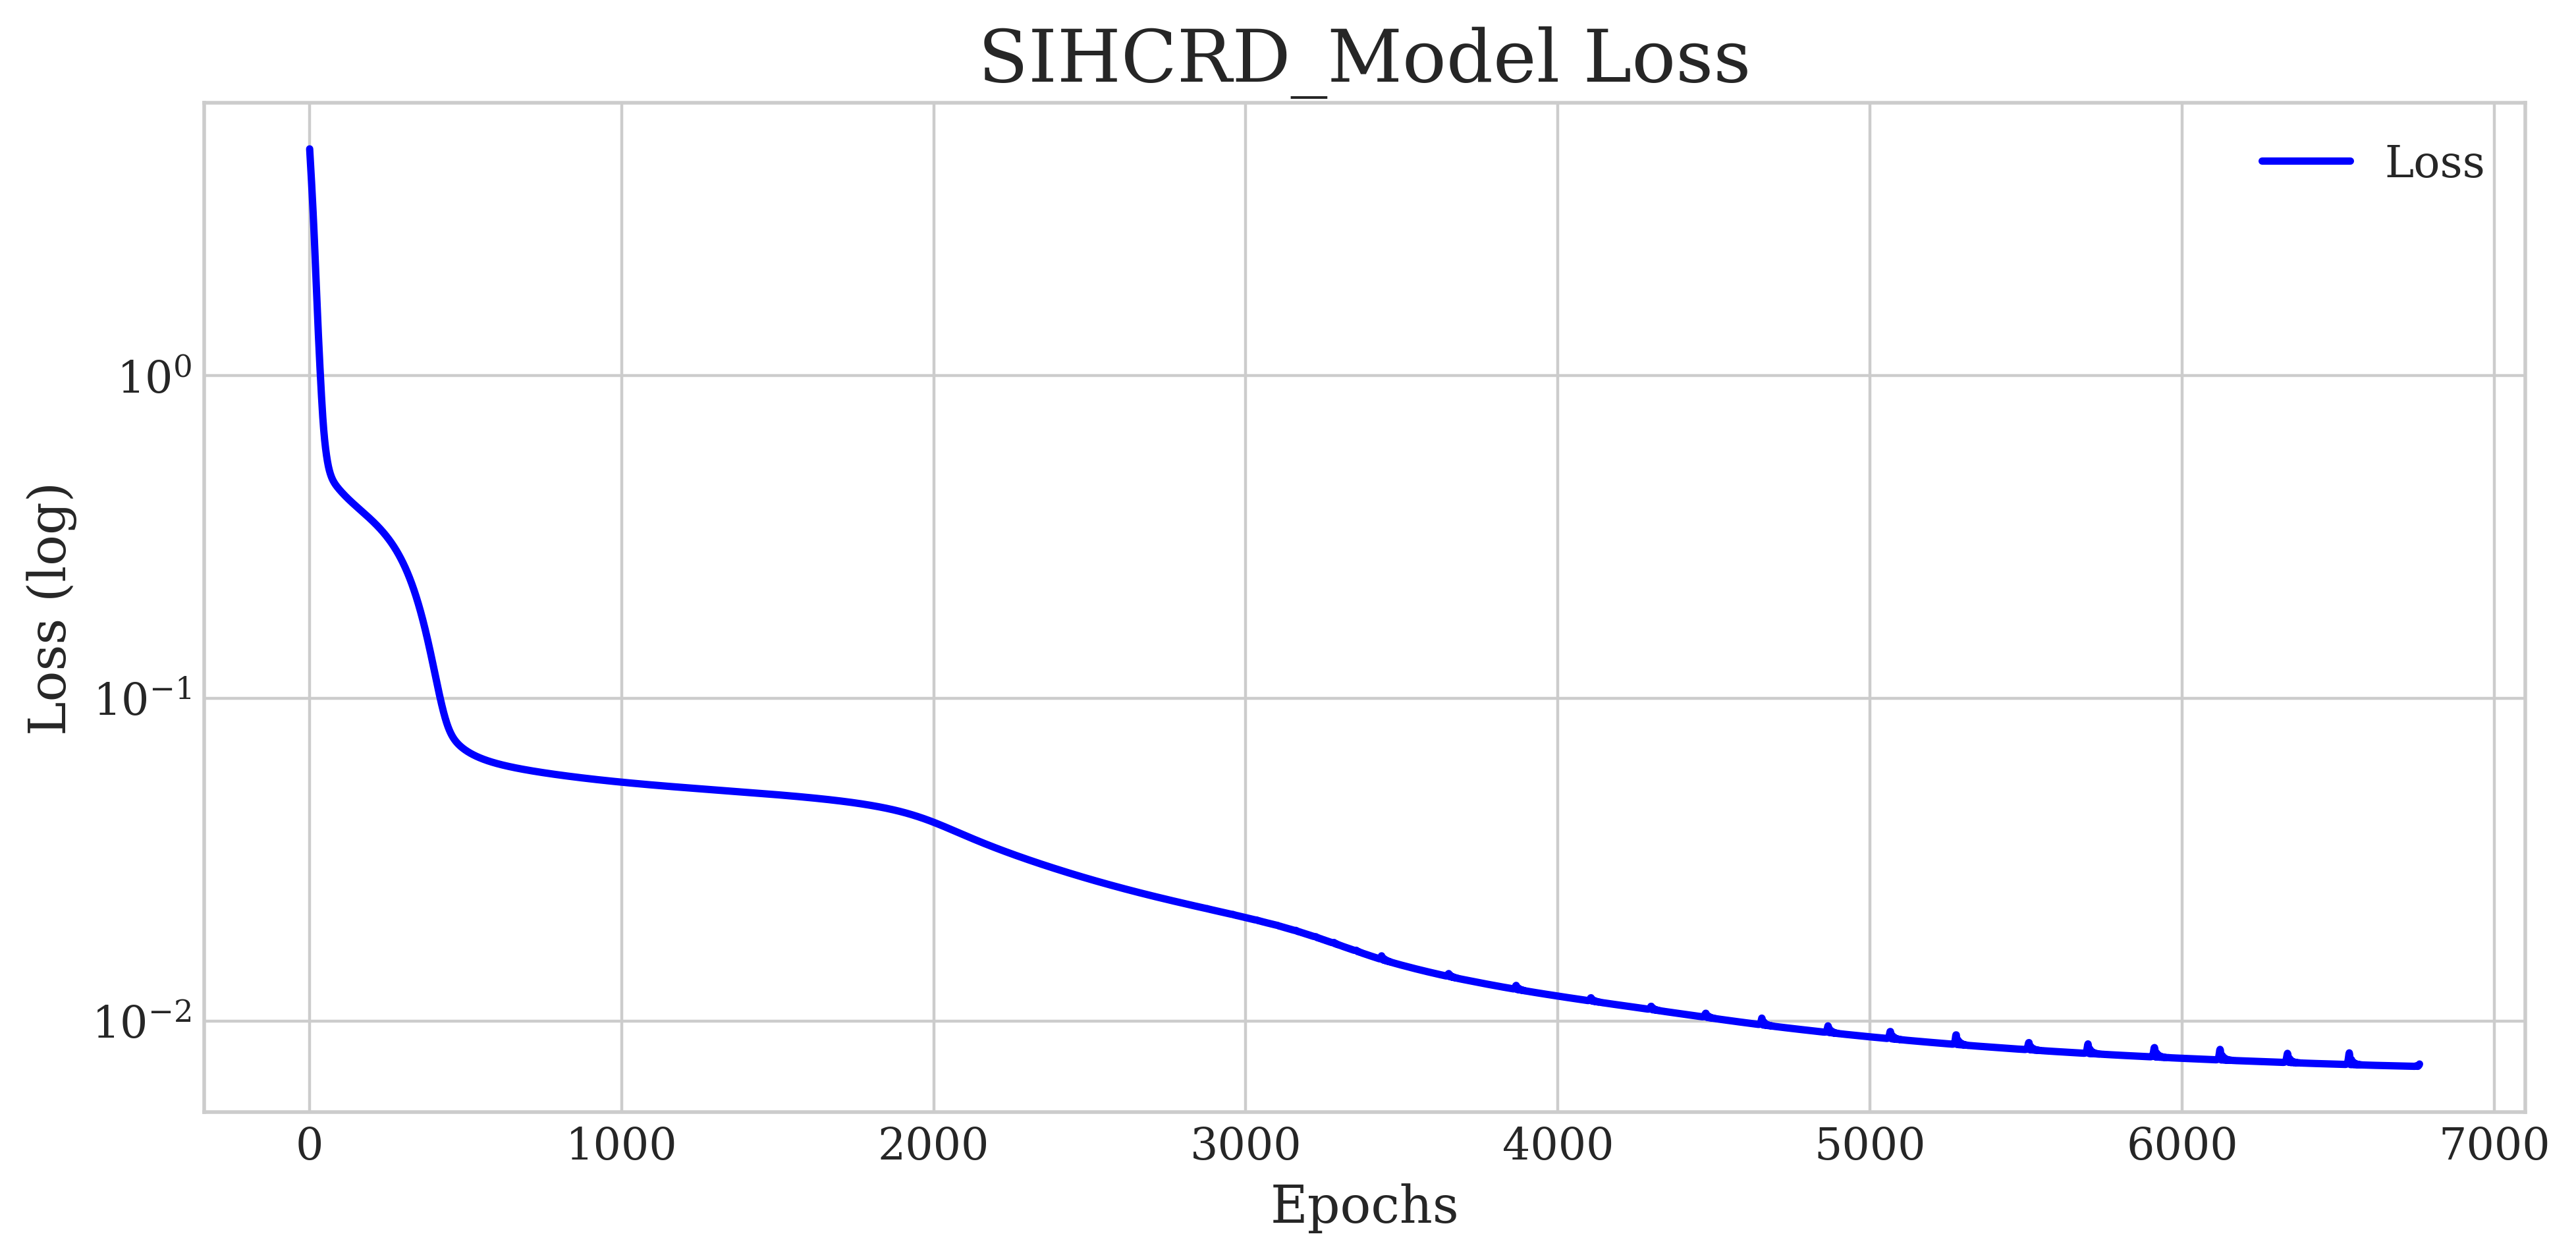

In [19]:
def plot_loss(
    losses,
    title,
    save_path="reports/figures",
    show=True,
    figsize=(10, 5),
    grid=True,
    save_format="pdf",
):
    """
    Enhanced plotting function for the training loss of a model, with logarithmic y-axis.

    Args:
    - losses (list or dict): A list of loss values per epoch, or a dictionary of lists for multiple loss components.
    - title (str): Title for the plot.
    - save_path (str, optional): Directory to save the plot. Default is "reports/figures".
    - show (bool, optional): Whether to display the plot. Default is True.
    - figsize (tuple, optional): Figure size. Default is (8, 5).
    - grid (bool, optional): Whether to show grid lines. Default is True.
    - save_format (str, optional): Format to save the plot (e.g., 'pdf', 'png'). Default is 'pdf'.

    Returns:
    None
    """
    
    # Logarithmic y-axis scale for the loss10 plot starting from epoch 1 (not 0) for better visualization
    plt.figure(figsize=figsize)
    plt.plot(np.arange(1, len(losses) + 1), losses, label="Loss", color="blue")
    plt.yscale("log")
    plt.title(f"{title} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (log)")
    plt.legend()
    # plt.grid(grid)
    
    # Save the plot if a path is provided
    
    
    if save_path:
        plt.savefig(f"{save_path}/{title.replace(' ', '_')}_Loss_of_PINNs_log.{save_format}")
    if show:
        plt.show()
        
plot_loss(losses, "SIHCRD_Model")

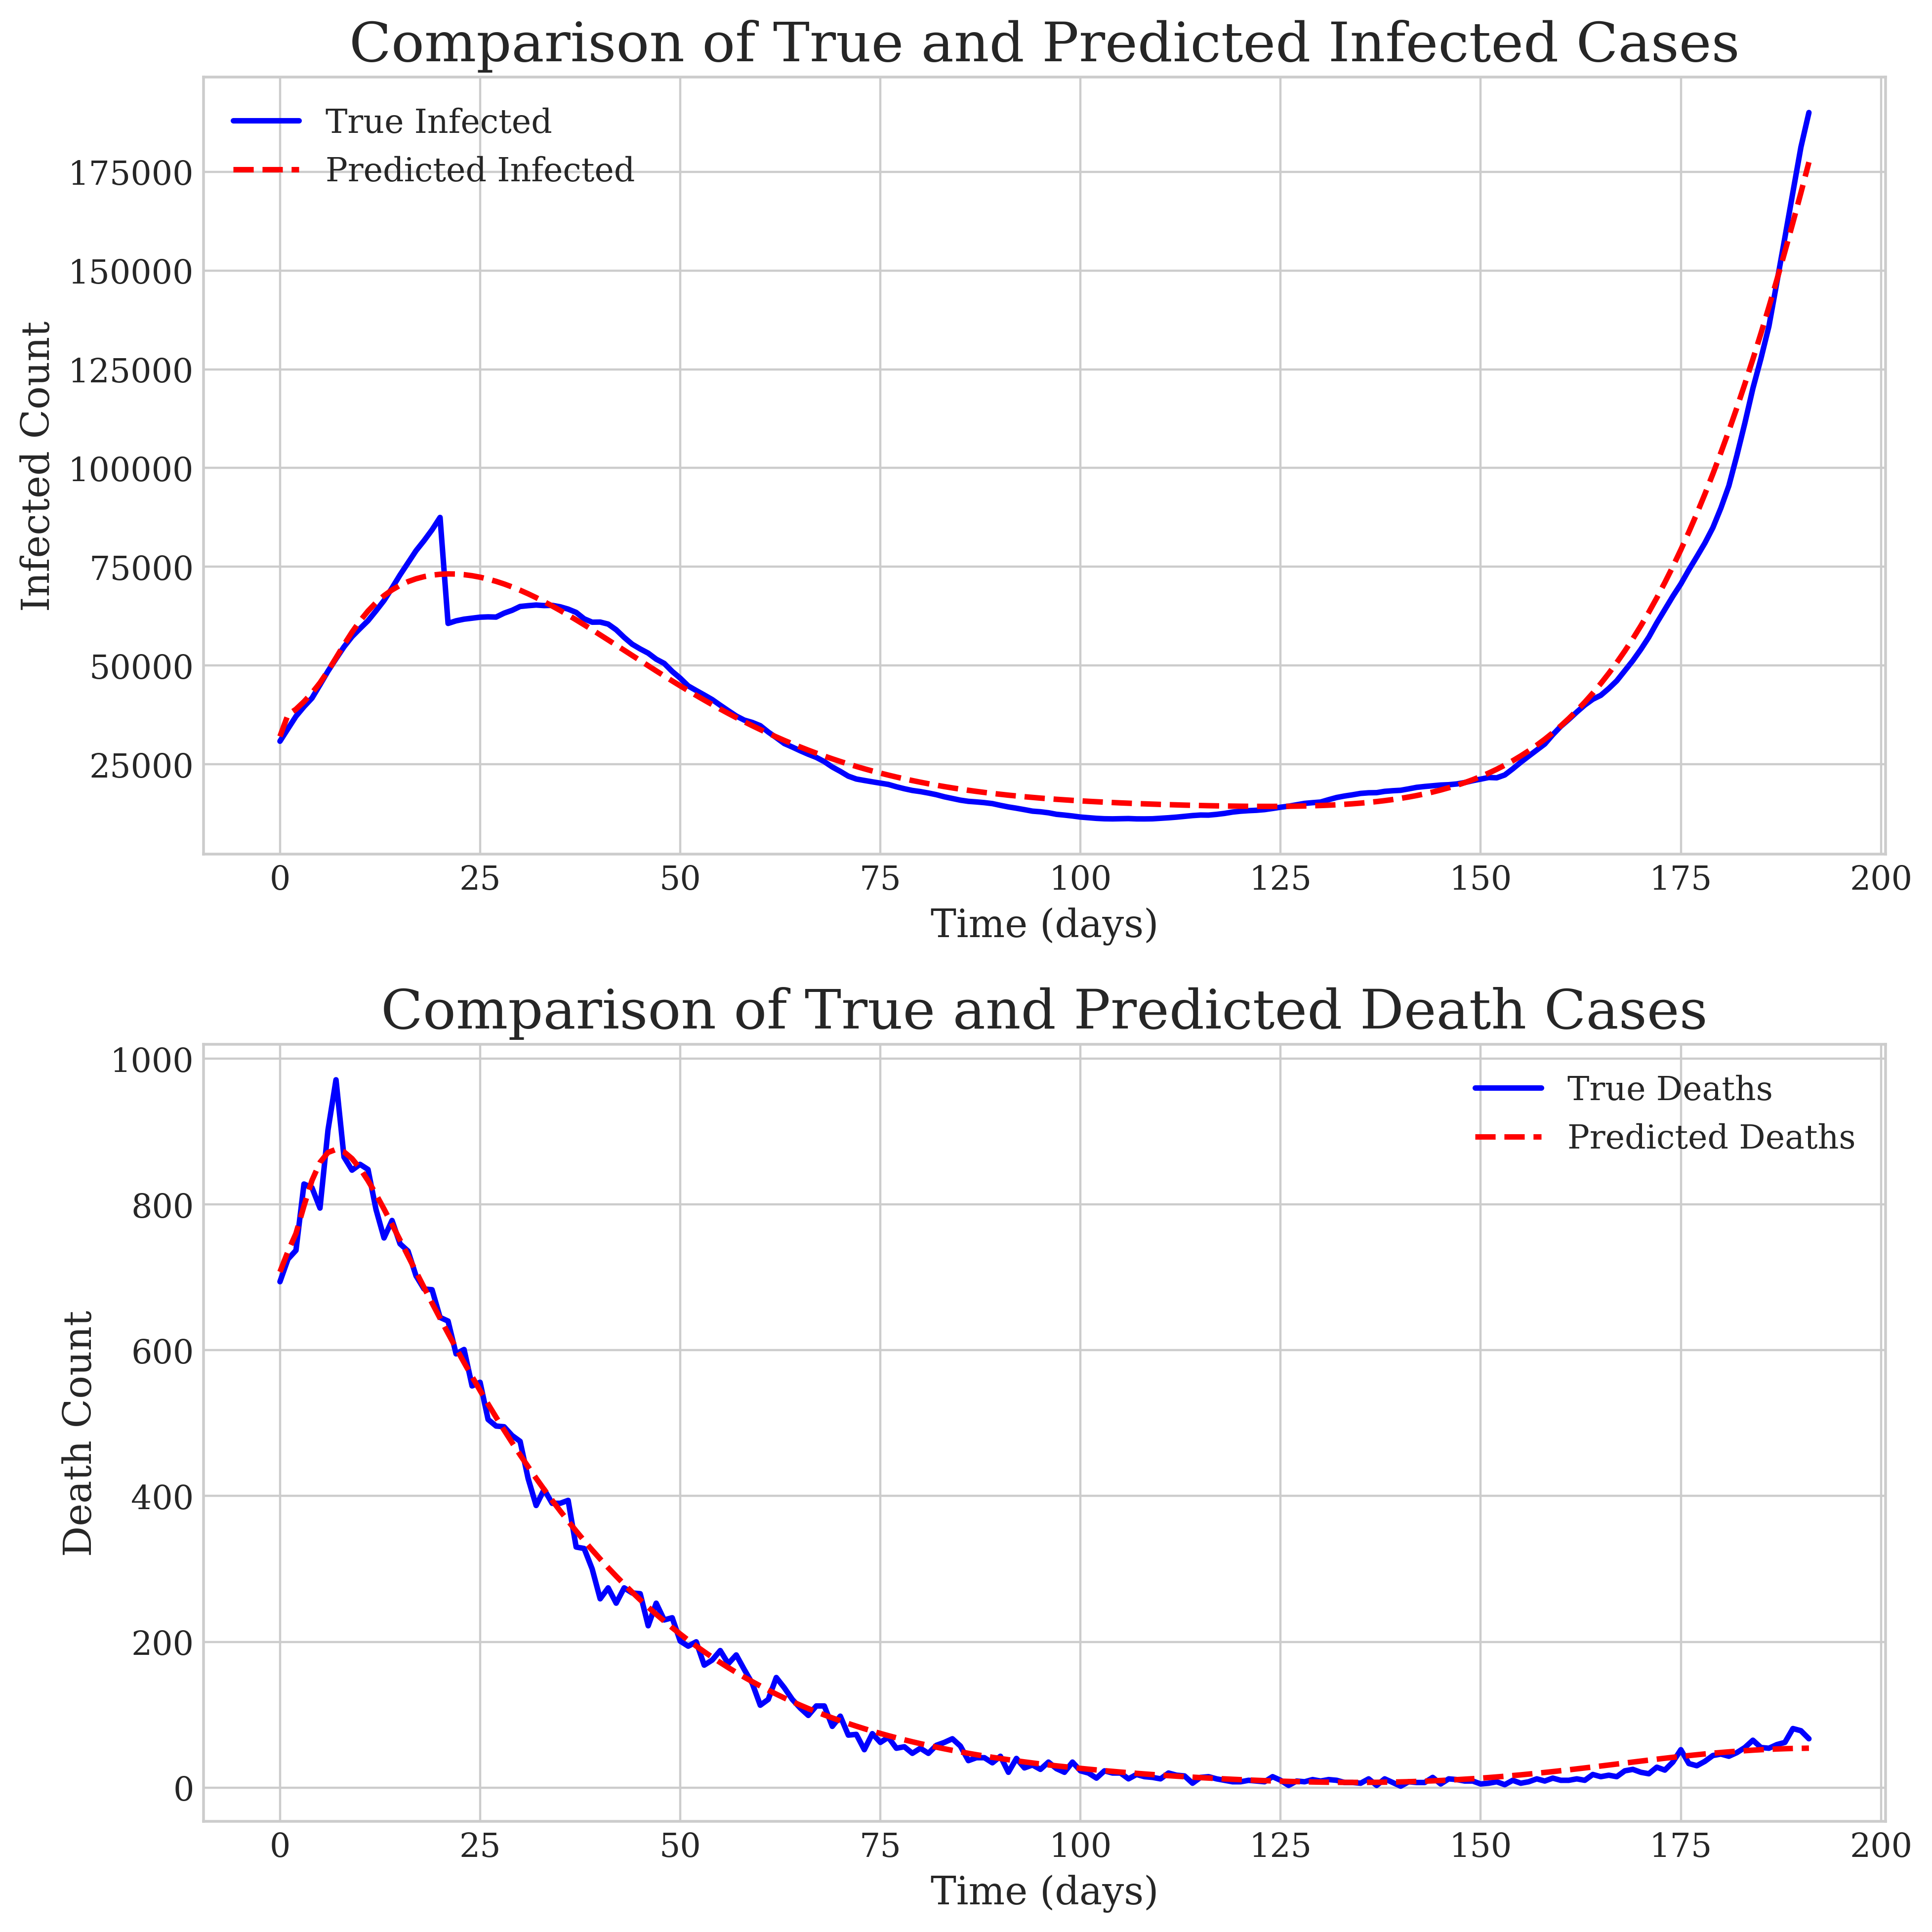

In [22]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(t_train).cpu()  # Move tensors to CPU for plotting

# Extract predictions into individual components
S_pred, I_pred, H_pred, C_pred, R_pred, D_pred = predictions[:, 0], predictions[:, 1], predictions[:, 2], predictions[:, 3], predictions[:, 4], predictions[:, 5]

# Extract true values from the tensor
S_true, I_true, H_true, C_true, R_true, D_true = SIHCRD_tensor_train[:, 0], SIHCRD_tensor_train[:, 1], SIHCRD_tensor_train[:, 2], SIHCRD_tensor_train[:, 3], SIHCRD_tensor_train[:, 4], SIHCRD_tensor_train[:, 5]


# Ensure all tensors are on CPU before converting to NumPy arrays for scaling
S_pred = S_pred.cpu()
I_pred = I_pred.cpu()
H_pred = H_pred.cpu()
C_pred = C_pred.cpu()
R_pred = R_pred.cpu()
D_pred = D_pred.cpu()

S_true = S_true.cpu()
I_true = I_true.cpu()
H_true = H_true.cpu()
C_true = C_true.cpu()
R_true = R_true.cpu()
D_true = D_true.cpu()

# Prepare data for rescaling
rescaled_pred = scaler.inverse_transform(
    np.concatenate(
        [
            S_pred.view(-1, 1).numpy(),
            I_pred.view(-1, 1).numpy(),
            H_pred.view(-1, 1).numpy(),
            C_pred.view(-1, 1).numpy(),
            R_pred.view(-1, 1).numpy(),
            D_pred.view(-1, 1).numpy(),
        ],
        axis=1,
    )
)

rescaled_true = scaler.inverse_transform(
    np.concatenate(
        [
            S_true.view(-1, 1).numpy(),
            I_true.view(-1, 1).numpy(),
            H_true.view(-1, 1).numpy(),
            C_true.view(-1, 1).numpy(),
            R_true.view(-1, 1).numpy(),
            D_true.view(-1, 1).numpy(),
        ],
        axis=1,
    )
)


# Extract rescaled infected and death counts
I_pred_rescaled = rescaled_pred[:, 1]  # 'I' is the second column for infected
D_pred_rescaled = rescaled_pred[:, 5]  # 'D' is the sixth column for deaths

I_true_rescaled = rescaled_true[:, 1]
D_true_rescaled = rescaled_true[:, 5]

# Create subplot grid for plotting (vertical layout)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 7))

# Plotting Infected Cases
axs[0].plot(I_true_rescaled, label='True Infected', color='blue')
axs[0].plot(I_pred_rescaled, label='Predicted Infected', color='red', linestyle='--')
axs[0].set_title('Comparison of True and Predicted Infected Cases')
axs[0].set_xlabel('Time (days)')
axs[0].set_ylabel('Infected Count')
axs[0].legend()

# Plotting Death Cases
axs[1].plot(D_true_rescaled, label='True Deaths', color='blue')
axs[1].plot(D_pred_rescaled, label='Predicted Deaths', color='red', linestyle='--')
axs[1].set_title('Comparison of True and Predicted Death Cases')
axs[1].set_xlabel('Time (days)')
axs[1].set_ylabel('Death Count')
axs[1].legend()

plt.tight_layout()
plt.show()

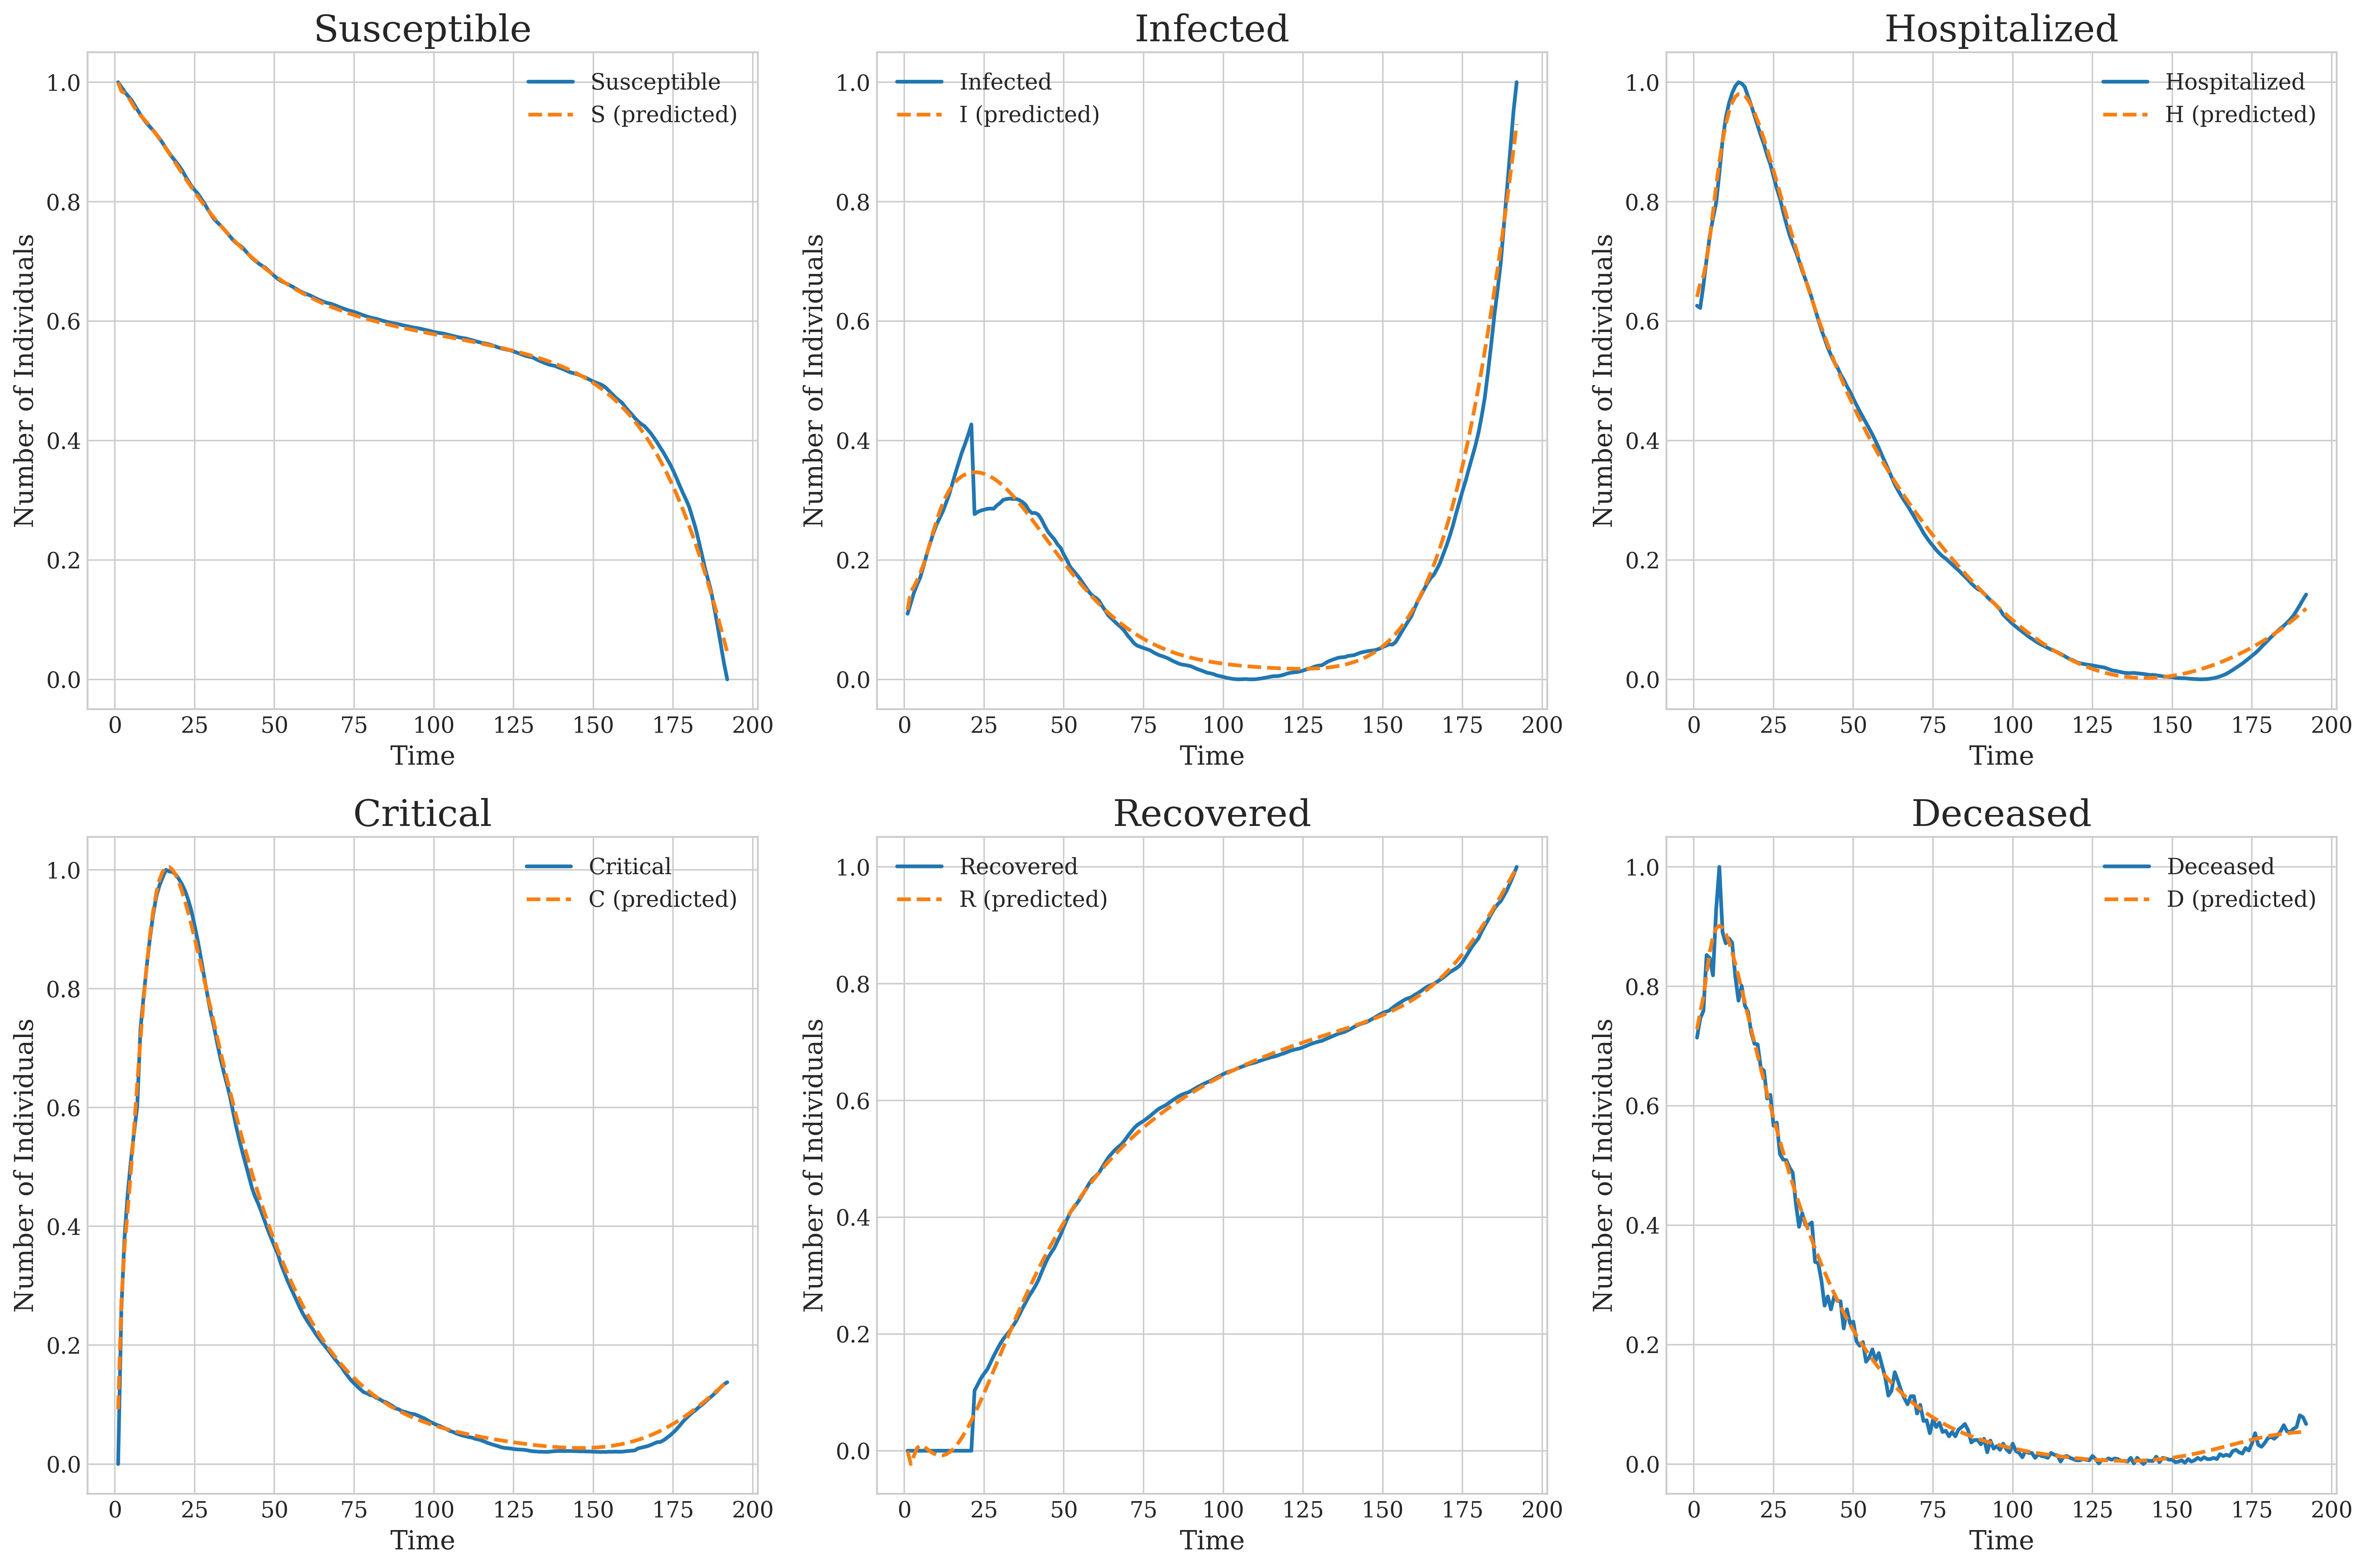

In [20]:
def plot_sihcrd_results(t, S, I, H, C, R, D, model, title):
    model.eval()
    with torch.no_grad():
        predictions = model(t).cpu().numpy()

    t_np = t.cpu().detach().numpy().flatten()
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # Adjusted for SIHCRD compartments

    compartments = [
        "Susceptible",
        "Infected",
        "Hospitalized",
        "Critical",
        "Recovered",
        "Deceased",
    ]
    data = [S, I, H, C, R, D]
    pred_labels = [
        "S (predicted)",
        "I (predicted)",
        "H (predicted)",
        "C (predicted)",
        "R (predicted)",
        "D (predicted)",
    ]

    for ax, comp_data, pred, label, pred_label in zip(
        axs.flat, data, predictions.T, compartments, pred_labels
    ):
        if comp_data is not None:
            ax.plot(t_np, comp_data.cpu().detach().numpy().flatten(), label=label)
        ax.plot(t_np, pred, linestyle="dashed", label=pred_label)
        ax.set_title(label)
        ax.set_xlabel("Time")
        ax.set_ylabel("Number of Individuals")
        ax.legend()

    plt.tight_layout()
    plt.savefig(f"reports/figures/{title}.pdf")
    plt.show()

# Plot the SIHCRD model results
plot_sihcrd_results(t_train, S_train, I_train, H_train, C_train, R_train, D_train, model, "SIHCRD_Model_Predictions")

In [21]:
def train_sihcrd(
    model,
    t_tensor,
    SIHCRD_tensor,
    epochs=1000,
    lr=0.001,
    N=None,
    beta=None,
    gamma=None,
    rho=None,
    eta=None,
    theta=None,
):
    # Setup optimizer and learning rate scheduler
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # scheduler = ReduceLROnPlateau(optimizer, "min", factor=0.1, patience=1000)
    early_stopping = EarlyStopping(patience=20, verbose=True)

    losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        model_output = model(t_tensor)

        # Calculate the loss
        loss = sihcrd_loss(
            model,
            model_output,
            SIHCRD_tensor,
            t_tensor,
            N,
            beta,
            gamma,
            rho,
            eta,
            theta,
        )

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        # scheduler.step(loss)

        # append the loss
        losses.append(loss.item())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

        early_stopping(loss)
        if early_stopping.early_stop:
            print("Early stopping")

            # save the best model
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    # "scheduler_state_dict": scheduler.state_dict(),
                    "loss": loss,
                },
                f"../../models/{model.__class__.__name__}.pt",
            )
            print("Model saved")
            break

    print("Training finished")

    return losses

In [22]:
# parameter estimation neural network where 
class ParamNet(nn.Module):
    def __init__(self, output_size=2, num_layers=3, hidden_neurons=20):
        super(ParamNet, self).__init__()
        layers = [nn.Linear(1, hidden_neurons), nn.ReLU()]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_neurons, hidden_neurons), nn.ReLU()])
        layers.append(nn.Linear(hidden_neurons, output_size))
        self.net = nn.Sequential(*layers)

    def forward(self, t):
        return self.net(t)
    
    # parameter estimation range for beta 0.1 to 1.0
    @property
    def beta(self):
        return torch.sigmoid(self._beta) * 0.9 + 0.1 if self._beta is not None else None
    
    # parameter estimation range for gamma 0.01 to 0.2
    @property
    def gamma(self):
        return torch.sigmoid(self._gamma) * 0.19 + 0.01 if self._gamma is not None else None
    
    # parameter estimation range for rho 0.01 to 0.2
    @property
    def rho(self):
        return torch.sigmoid(self._rho) * 0.19 + 0.01 if self._rho is not None else None
    
    # parameter estimation range for eta 0.01 to 0.2
    @property
    def eta(self):
        return torch.sigmoid(self._eta) * 0.19 + 0.01 if self._eta is not None else None
    
        

# class GRUParamNet(nn.Module):
#     def __init__(self, input_size=1, hidden_size=20, num_layers=1, output_size=7):
#         """
#         Initializes the GRUParamNet model.
#         input_size: int, number of input features (default is 1 for time).
#         hidden_size: int, number of features in the hidden state of the GRU.
#         num_layers: int, number of recurrent layers.
#         output_size: int, number of output parameters to estimate.
#         """
#         super(GRUParamNet, self).__init__()
#         self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         """
#         Forward pass through the GRU model followed by a linear layer.
#         x: torch.Tensor, input tensor of shape (batch_size, sequence_length, input_size).
#         """
#         x, h_n = self.gru(x)  # x: (batch_size, seq_len, hidden_size), h_n: (num_layers, batch_size, hidden_size)
#         # We use the last hidden state
#         x = x[:, -1, :]
#         x = self.fc(x)
#         # Apply sigmoid activation function to ensure outputs are in the range (0, 1)
#         parameters = torch.sigmoid(x)
        
#         # Scale parameters according to their expected ranges
#         beta = parameters[:, 0] * 0.9 + 0.1 
#         gamma = parameters[:, 1] * 0.09 + 0.01
#         rho = parameters[:, 2] * 0.09 + 0.01
#         eta = parameters[:, 3] * 0.09 + 0.01
#         theta = parameters[:, 4] * 0.009 + 0.001
#         return beta, gamma, rho, eta, theta
    
        


class EpiNet(nn.Module):
    def __init__(self, num_layers=3, hidden_neurons=20):
        super(EpiNet, self).__init__()
        self.retrain_seed = 42  # Set the retrain_seed for reproducibility
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_neurons, hidden_neurons), nn.Tanh()])
        layers.append(nn.Linear(hidden_neurons, 3))  # Output: S, I, R
        self.net = nn.Sequential(*layers)
        self.init_xavier()

    def forward(self, t):
        return self.net(t)

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if isinstance(m, nn.Linear):
                g = nn.init.calculate_gain("tanh")
                nn.init.xavier_uniform_(m.weight, gain=g)
                if m.bias is not None:
                    m.bias.data.fill_(0)

        self.apply(init_weights)

In [ ]:
# Define the loss function for the SIHCRD model
def sihcrd_loss(
    model,
    model_output,
    SEIHCRD_tensor,
    t_tensor,
    N=None,
    beta_pred=None,
    sigma_pred=None,
    gamma_pred=None,
    rho_pred=None,
    eta_pred=None,
    theta_pred=None,
    kappa_pred=None,
    mu_pred=None,
    xi_pred=None,
    delta_pred=None,
):
    S_pred, E_pred, I_pred, H_pred, C_pred, R_pred, D_pred = model_output[:, 0], model_output[:, 1], model_output[:, 2], model_output[:, 3], model_output[:, 4], model_output[:, 5], model_output[:, 6] 
    
    S_actual, E_actual, I_actual, H_actual, C_actual, R_actual, D_actual = SEIHCRD_tensor[:, 0], SEIHCRD_tensor[:, 1], SEIHCRD_tensor[:, 2], SEIHCRD_tensor[:, 3], SEIHCRD_tensor[:, 4], SEIHCRD_tensor[:, 5], SEIHCRD_tensor[:, 6]

    # Derivatives of the compartments with respect to time
    S_t = torch.autograd.grad(S_pred, t_tensor, torch.ones_like(S_pred), create_graph=True)[0]  
    E_t = torch.autograd.grad(E_pred, t_tensor, torch.ones_like(E_pred), create_graph=True)[0]
    I_t = torch.autograd.grad(I_pred, t_tensor, torch.ones_like(I_pred), create_graph=True)[0]
    H_t = torch.autograd.grad(H_pred, t_tensor, torch.ones_like(H_pred), create_graph=True)[0]
    C_t = torch.autograd.grad(C_pred, t_tensor, torch.ones_like(C_pred), create_graph=True)[0]
    R_t = torch.autograd.grad(R_pred, t_tensor, torch.ones_like(R_pred), create_graph=True)[0]
    D_t = torch.autograd.grad(D_pred, t_tensor, torch.ones_like(D_pred), create_graph=True)[0]

    # Differential equations for the SIHCRD model
    dSdt = -(beta_pred * S_pred * I_pred) / N
    dEdt = (beta_pred * S_pred * I_pred) / N - sigma_pred * E_pred
    dIdt = sigma_pred * E_pred - gamma_pred * I_pred - rho_pred * I_pred
    dHdt = rho_pred * I_pred - eta_pred * H_pred - gamma_pred * H_pred
    dCdt = eta_pred * H_pred - theta_pred * C_pred - gamma_pred * C_pred
    dRdt = gamma_pred * (I_pred + H_pred + C_pred)
    dDdt = theta_pred * C_pred

    # Physics-informed loss: the difference between the predicted derivatives and the actual rate of change
    physics_loss = torch.mean((S_t - dSdt) ** 2) + torch.mean((E_t - dEdt) ** 2) + \
                   torch.mean((I_t - dIdt) ** 2) + torch.mean((H_t - dHdt) ** 2) + \                   
                   torch.mean((C_t - dCdt) ** 2) + torch.mean((R_t - dRdt) ** 2) + \
                   torch.mean((D_t - dDdt) ** 2)     

    # data loss
    data_loss = torch.mean((S_actual - S_pred) ** 2) + torch.mean((E_actual - E_pred) ** 2) + \
                torch.mean((I_actual - I_pred) ** 2) + torch.mean((H_actual - H_pred) ** 2) + \
                torch.mean((C_actual - C_pred) ** 2) + torch.mean((R_actual - R_pred) ** 2) + \
                torch.mean((D_actual - D_pred) ** 2)

    total_loss = data_loss + physics_loss
    return total_loss

In [ ]:
# Early stopping class
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [ ]:
# Initialize the models
param_model = GRUParamNet(input_size=1, hidden_size=32, num_layers=5).to(device)
epi_model = EpiNet(num_layers=5, hidden_neurons=32).to(device)

In [ ]:
# Training function
def time_varying_PINN_training(param_model, epi_model, train_loader, optimizer, epochs):
    """
    Function to train the time-varying PINN model.
    param_model: nn.Module, the parameter estimation model.
    epi_model: nn.Module, the epidemiological model.
    train_loader: DataLoader, the training data loader.
    optimizer: torch.optim.Optimizer, the optimizer for training.
    epochs: int, the number of training epochs.
    """
    # Initialize the early stopping callback
    early_stopping = EarlyStopping(patience=10, verbose=True)
    
    losses = []     # List to store the losses  

    # Training loop
    for epoch in tqdm(range(epochs), desc="Training", unit="epoch", position=0, leave=True):
        
        # Set the model to training mode
        param_model.train()
        epi_model.train()
        
        # forward pass: compute predicted outputs by passing inputs to the model, and parameter estimation model
        beta_pred, gamma_pred, rho_pred, eta_pred, theta_pred = param_model(train_loader)
        S_pred, I_pred, H_pred, C_pred, R_pred, D_pred = epi_model(train_loader)    

In [ ]:
losses = 

SyntaxError: invalid syntax (1284818843.py, line 1)